This notebook does two things: 1) tracks the co-firing of cells as it increases/decreases on each day, and 2) tests whether day 4 (learning-related) increases in syncrony persist with the same cell pairs between controls and ANI mice.

## NRK todo: remake all analyses not tracking cells across days with d1_d2 as same day, e.g. '4_4'.  Will make life easier in future!

In [40]:
# Import useful modules
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.gridspec as gridspec
import pandas as pd
from tqdm import tqdm

# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

from session_directory import find_eraser_directory as get_dir
import er_plot_functions as erp
import Placefields as pf
import freezing_analysis as fa
import helpers 
import eraser_reference as err
import covariance_analysis as cova

# Project save directory here
print_dir = '/Users/nkinsky/Documents/BU/Working/Eraser/plots'
save_dir = '/Users/nkinsky/Documents/BU/Working/Eraser'

plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['']
plt.rcParams['font.sans-serif'] = "Arial"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Helper functions to block printing output
import sys, os

# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__


## Bug here - why isn't this fix working!!!
Should be fixed now - re-test all code below with updates, make sure to change 'before', 'during', and 'after' inputs and get rid of any refs to 'add_reg_memory_designation' function

In [185]:
from copy import deepcopy

def add_memory_designations(df_use, before=['-2_-1', '-1_4'], during=['4_1'], after=['1_2', '2_7']):
    """Add in designations for before, 4hr (during), and after ANI administration into your dataframe"""
    df = deepcopy(df_use)
    desig = ["" for a in df.itertuples()]
    
    def create_bool_array_from_list(bool_list):
        bool_out = False
        for b in bool_list:
            bool_out = np.bitwise_or(bool_out, b)
            
        return bool_out
    
    before_bool_list = [df["d1_d2"] == bef for bef in before]
    before_ind = np.where(create_bool_array_from_list(before_bool_list))[0]
    during_bool_list = [df["d1_d2"] == dur for dur in during]
    during_ind = np.where(create_bool_array_from_list(during_bool_list))[0]
    after_bool_list = [df["d1_d2"] == aft for aft in after]
    after_ind = np.where(create_bool_array_from_list(after_bool_list))[0]
    
       # Old hardcoded method below for reference/bug checking
#     before_ind = np.where((df["d1_d2"] == "-2_-1") | (df["d1_d2"] == "-1_4"))[0]
#     during_ind = np.where(df["d1_d2"] == "4_1")[0]
#     after_ind = np.where((df["d1_d2"] == "1_2") | (df["d1_d2"] == "2_7"))[0]
    for idd, d in enumerate(desig):
        if idd in before_ind:
            desig[idd] = "Before"
        elif idd in during_ind:
            desig[idd] = "4hr"
        elif idd in after_ind:
            desig[idd] = "After"
    df.insert(1, "Designation", desig)
    
    return df

In [71]:
def add_reg_memory_designations(df_use):
    """Add in designations for before, 4hr (during), and after ANI administration into your dataframe"""
    df = deepcopy(df_use)
    desig = ["" for a in df.itertuples()]
    before_ind = np.where((df["d1_d2"] == "4_-2") | (df["d1_d2"] == "4_-1"))[0]
    during_ind = np.where(df["d1_d2"] == "4_4")[0]
    after_ind = np.where((df["d1_d2"] == "4_1") | (df["d1_d2"] == "4_2"))[0]
    for idd, d in enumerate(desig):
        if idd in before_ind:
            desig[idd] = "Before"
        elif idd in during_ind:
            desig[idd] = "4hr"
        elif idd in after_ind:
            desig[idd] = "After"
    df.insert(1, "Designation", desig)
    
    return df

In [96]:
def stats_before_after(df_use, key_use, ax=None):
    """Compares mean covariances in a DataFrame. Pools days before (-2 and -1) and days after (1 and 2) shock + 
    injection. Compares across and within groups.
    :param reg: True = use reg_memory_designations, False = use regular memory degisnations"""
    
    df_before = df_use[df_use['Designation'] == 'Before']
    df_after = df_use[df_use['Designation'] == 'After']
    df4 = df_use[df_use['Designation'] == '4hr'] 
        
    stat_bef, p_bef = stats.ttest_ind(df_before[df_before['Group'] == 'Ctrl'][key_use], 
                                     df_before[df_before['Group'] == 'ANI'][key_use])
    stat_aft, p_aft = stats.ttest_ind(df_after[df_after['Group'] == 'Ctrl'][key_use], 
                                     df_after[df_after['Group'] == 'ANI'][key_use])
    stat_ctrl, p_ctrl = stats.ttest_ind(df_before[df_before['Group'] == 'Ctrl'][key_use], 
                                     df_after[df_after['Group'] == 'Ctrl'][key_use])
    stat_ani, p_ani = stats.ttest_ind(df_before[df_before['Group'] == 'ANI'][key_use], 
                                     df_after[df_after['Group'] == 'ANI'][key_use])
    stat_dur, p_dur = stats.ttest_ind(df4[df4['Group'] == 'Ctrl'][key_use],
                                     df4[df4['Group'] == 'ANI'][key_use])
    
    if ax is None:  # Print to screen
        print(f'p={p_bef:0.3g} baseline b/w groups')
        print(f'p={p_aft:0.3g} day 1-2 b/w groups')
        print(f'p={p_ctrl:0.3g} before-after Ctrl')
        print(f'p={p_ani:0.3g} before-after ANI')
        print(f'p={p_dur:0.3g} 4 hrs b/w groups')
    else:  # Print into specified axes
        ax.text(0.1, 0.5, f'p={p_bef:0.3g} baseline b/w groups')
        ax.text(0.1, 0.4, f'p={p_aft:0.3g} day 1-2 b/w groups')
        ax.text(0.1, 0.3, f'p={p_ctrl:0.3g} before-after Ctrl')
        ax.text(0.1, 0.2, f'p={p_ani:0.3g} before-after ANI')
        ax.text(0.1, 0.1, f'p={p_dur:0.3g} 4 hrs b/w groups')

Step 0: Set up all dicts for plotting.

In [7]:
bin_size = 0.5 # sec
all_cov = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                               neurons='all', keep_silent=True)
freeze_silent_cov = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                               neurons='freeze_onset', keep_silent=True)

Marble07: 5it [00:03,  1.37it/s]

No tunings found for Marble07 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble07: 6it [00:04,  1.37it/s]
Marble12: 5it [00:03,  1.59it/s]

No tunings found for Marble12 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble12: 6it [00:03,  1.59it/s]
Marble24: 5it [00:03,  1.54it/s]

No tunings found for Marble24 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble24: 6it [00:03,  1.57it/s]
Marble27: 5it [00:03,  1.54it/s]

No tunings found for Marble27 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble27: 6it [00:03,  1.54it/s]
Marble06: 4it [00:02,  1.50it/s]

No position data found for Marble06 Shock day 7, loading neural data only


Marble06: 6it [00:05,  1.07it/s]
Marble11: 5it [00:04,  1.08it/s]

No tunings found for Marble11 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble11: 6it [00:05,  1.07it/s]
Marble29: 5it [00:03,  1.48it/s]

No tunings found for Marble29 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble29: 6it [00:04,  1.47it/s]
Marble17: 5it [00:03,  1.28it/s]

No tunings found for Marble17 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble17: 6it [00:04,  1.27it/s]
Marble18: 5it [00:03,  1.65it/s]

No tunings found for Marble18 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble18: 6it [00:03,  1.66it/s]
Marble19: 5it [00:03,  1.44it/s]

No tunings found for Marble19 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble19: 6it [00:04,  1.46it/s]
Marble20: 5it [00:03,  1.59it/s]

No tunings found for Marble20 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble20: 6it [00:03,  1.62it/s]
Marble25: 5it [00:03,  1.43it/s]

No tunings found for Marble25 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble25: 6it [00:04,  1.44it/s]
Marble07: 4it [00:03,  1.01it/s]

No tunings found for Marble07 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble07: 6it [00:05,  1.01it/s]
Marble12: 4it [00:03,  1.18it/s]

No tunings found for Marble12 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble12: 6it [00:05,  1.18it/s]
Marble24: 4it [00:03,  1.17it/s]

No tunings found for Marble24 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble24: 6it [00:05,  1.16it/s]
Marble27: 4it [00:04,  1.03it/s]

No tunings found for Marble27 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble27: 6it [00:05,  1.04it/s]
Marble06: 4it [00:03,  1.08it/s]

No position data found for Marble06 Shock day 7, loading neural data only


Marble06: 6it [00:07,  1.18s/it]
Marble11: 4it [00:04,  1.19s/it]

No tunings found for Marble11 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble11: 6it [00:07,  1.19s/it]
Marble29: 4it [00:03,  1.09it/s]

No tunings found for Marble29 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble29: 6it [00:05,  1.08it/s]
Marble17: 4it [00:04,  1.05s/it]

No tunings found for Marble17 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble17: 6it [00:06,  1.04s/it]
Marble18: 4it [00:03,  1.22it/s]

No tunings found for Marble18 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble18: 6it [00:04,  1.22it/s]
Marble19: 4it [00:03,  1.09it/s]

No tunings found for Marble19 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble19: 6it [00:05,  1.08it/s]
Marble20: 4it [00:03,  1.21it/s]

No tunings found for Marble20 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble20: 6it [00:04,  1.20it/s]
Marble25: 4it [00:03,  1.07it/s]

No tunings found for Marble25 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble25: 6it [00:05,  1.06it/s]


Plot #1: Freeze cell covariance before (day -1 and -2), 4 hr, and after (day 1 and 2), all normalized to day -2.  

### NRK important note - try with keep_silent=False - all the above is probably driven by silent cells!  They are listed as 0 when they should be NaN by definition since the variance of a cell that fires no events is NaN, right?

NO! I'm only looking at base day covariances, which don't include silent cells! All good!

In [10]:
sigz_freeze_df = cova.cov_dict_to_df(freeze_silent_cov, baseline_dict_use=all_cov, include_silent=True)
sigz_freeze_df = add_memory_designations(sigz_freeze_df)

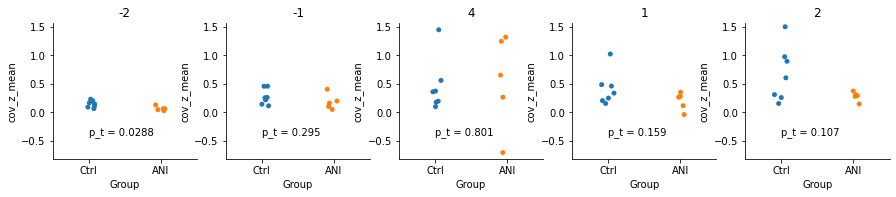

In [17]:
sigz_df = sigz_freeze_df

pairs_plot = ['-2_-1', '-1_4', '4_1', '1_2', '2_7']
fig, ax = plt.subplots(1, len(pairs_plot), figsize=(3*len(pairs_plot), 2.5))
for a, d1_d2 in zip(ax, pairs_plot):
    sns.stripplot(x='Group', y='cov_z_mean', data=sigz_df[sigz_df['d1_d2'] == d1_d2], ax=a)
    sns.despine(ax=a)
    a.set_title(d1_d2.split('_')[0])
    df_use = sigz_df[sigz_df['d1_d2'] == d1_d2]
    stat, pval = stats.ttest_ind(df_use[df_use['Group'] == 'Ctrl']['cov_z_mean'], 
                                 df_use[df_use['Group'] == 'ANI']['cov_z_mean'])
    
    a.text(0, -0.4, f'p_t = {pval:.3g}')
    
erp.match_max_lims(ax, axis='y')

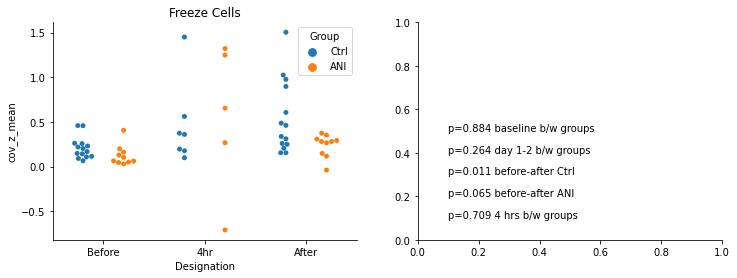

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.swarmplot(x="Designation", y="cov_z_mean", hue="Group", data=sigz_freeze_df, dodge=True, ax=ax[0])
ax[0].set_title('Freeze Cells')
sns.despine(fig=fig)
stats_before_after(sigz_df, 'cov_z_mean', ax=ax[1])
fig.savefig(print_dir + "/cov_before_after_freeze_cells.pdf")

Plot #2: Same as #1 but for all cells

In [177]:
allz_df = cova.cov_dict_to_df(all_cov, baseline_dict_use=all_cov, include_silent=True)
allz_df = add_memory_designations(allz_df)

before_ind = [ 0  1  6  7 12 13 18 19 24 25 30 31 36 37 42 43 48 49 54 55 60 61 66 67]


In [178]:
allz_df_copy = deepcopy(allz_df)
allz_df_copy.drop(['Designation'], axis=1, inplace=True)
print(allz_df.head(3))
print(allz_df_copy.head(3))
print(add_memory_designations(allz_df_copy).head(3))

   d1_d2 Designation Group  cov_z_mean
0  -2_-1      Before  Ctrl   -0.005070
1   -1_4      Before  Ctrl    0.006094
2    4_1         4hr  Ctrl    0.020956
   d1_d2 Group  cov_z_mean
0  -2_-1  Ctrl   -0.005070
1   -1_4  Ctrl    0.006094
2    4_1  Ctrl    0.020956
before_ind = [ 0  1  6  7 12 13 18 19 24 25 30 31 36 37 42 43 48 49 54 55 60 61 66 67]
   d1_d2 Designation Group  cov_z_mean
0  -2_-1      Before  Ctrl   -0.005070
1   -1_4      Before  Ctrl    0.006094
2    4_1         4hr  Ctrl    0.020956


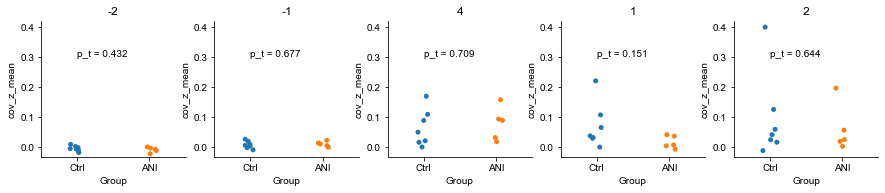

In [179]:
sigz_df = allz_df

pairs_plot = ['-2_-1', '-1_4', '4_1', '1_2', '2_7']
fig, ax = plt.subplots(1, len(pairs_plot), figsize=(3*len(pairs_plot), 2.5))
for a, d1_d2 in zip(ax, pairs_plot):
    sns.stripplot(x='Group', y='cov_z_mean', data=sigz_df[sigz_df['d1_d2'] == d1_d2], ax=a)
    sns.despine(ax=a)
    a.set_title(d1_d2.split('_')[0])
    df_use = sigz_df[sigz_df['d1_d2'] == d1_d2]
    stat, pval = stats.ttest_ind(df_use[df_use['Group'] == 'Ctrl']['cov_z_mean'], 
                                 df_use[df_use['Group'] == 'ANI']['cov_z_mean'])
    
    a.text(0, 0.3, f'p_t = {pval:.3g}')
    
erp.match_max_lims(ax, axis='y')

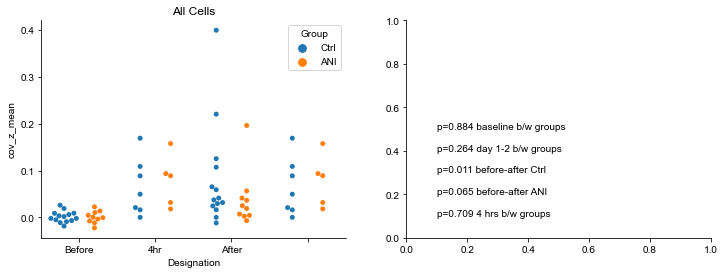

In [181]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))
sns.swarmplot(x="Designation", y="cov_z_mean", hue="Group", data=allz_df, dodge=True, ax=ax[0])
ax[0].set_title('All Cells')
sns.despine(fig=fig)
stats_before_after(allz_df, 'cov_z_mean', ax[1])
fig.savefig(print_dir + "/cov_before_after_all_cells.pdf")

Plot #3: Same as #1 and #2 but for all cells on 4 hr session which have covariance > 2std above mean.  This one might be messy due to lots of cell turnover in ANI mice.

In [73]:
sig4_cov_dict = cova.group_sig_cov_across_days(bin_size=bin_size, arena1='Shock',
                                              arena2='Shock', base_days=[4, 4, 4, 4, 4],
                                              reg_days=[-2, -1, 4, 1, 2], thresh=2,
                                              keep_silent=False)

Marble07: 5it [00:03,  1.30it/s]
Marble12: 5it [00:03,  1.63it/s]
Marble24: 5it [00:03,  1.64it/s]
Marble27: 5it [00:03,  1.55it/s]
Marble06: 5it [00:03,  1.43it/s]
Marble11: 5it [00:04,  1.11it/s]
Marble29: 5it [00:03,  1.50it/s]
Marble17: 5it [00:03,  1.29it/s]
Marble18: 5it [00:03,  1.65it/s]
Marble19: 5it [00:03,  1.50it/s]
Marble20: 5it [00:03,  1.66it/s]
Marble25: 5it [00:03,  1.49it/s]


In [74]:
# Clean up and reshape dataframe
sig4_dfreg = cova.cov_dict_to_df(sig4_cov_dict, all_cov, register=True)
sig4_dfreg = add_reg_memory_designations(sig4_dfreg)

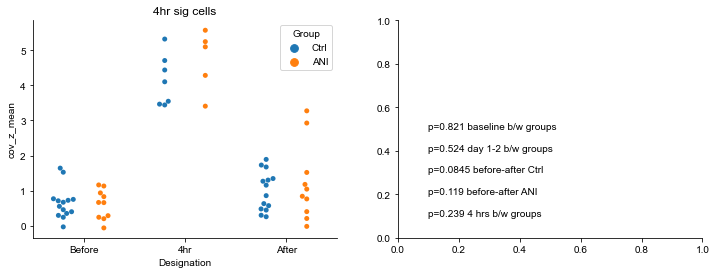

In [97]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))
sns.swarmplot(x="Designation", y="cov_z_mean", hue="Group", data=sig4_dfreg, dodge=True, ax=ax[0])
ax[0].set_title('4hr sig cells')
sns.despine(fig=fig)
stats_before_after(sig4_dfreg, 'cov_z_mean', ax[1])
fig.savefig(print_dir + "/cov_before_after_sig4_cells_registered_across_days.pdf")

Plot #4: ID freeze cells on 4 hr session and track covariance forward/backward across whole experiment.  Include silent cells in code, but plot two ways: 1) turnover in freeze cell population between sessions, and 2) change in covariance from 4 hr session forward/backward in time.  

In [195]:
freeze_4hr_reg = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                            neurons='freeze_onset', keep_silent=True,
                                            base_days=[4, 4, 4, 4, 4], reg_days=[-2, -1, 4, 1, 2])

Marble07: 5it [00:05,  1.04s/it]
Marble12: 5it [00:04,  1.19it/s]
Marble24: 5it [00:04,  1.18it/s]
Marble27: 5it [00:04,  1.13it/s]
Marble06: 5it [00:04,  1.10it/s]
Marble11: 5it [00:05,  1.19s/it]
Marble29: 5it [00:04,  1.03it/s]
Marble17: 5it [00:05,  1.07s/it]
Marble18: 5it [00:04,  1.22it/s]
Marble19: 5it [00:04,  1.04it/s]
Marble20: 5it [00:04,  1.17it/s]
Marble25: 5it [00:04,  1.10it/s]


In [196]:
# Clean up and reshape dataframe
sig4frz_dfreg = cova.cov_dict_to_df(freeze_4hr_reg, all_cov, register=True)
sig4frz_dfreg = add_memory_designations(sig4frz_dfreg, before=['4_-2', '4_-1'], during=['4_4'], after=['4_1', '4_2'])

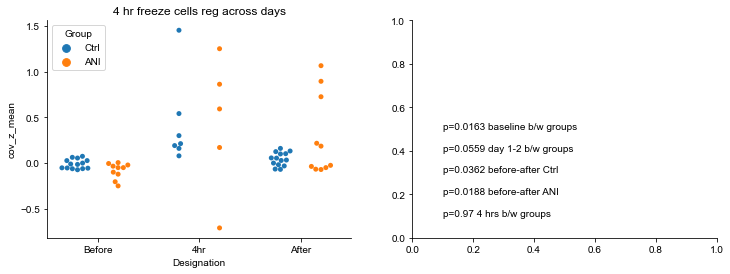

In [198]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))
sns.swarmplot(x="Designation", y="cov_z_mean", hue="Group", data=sig4frz_dfreg, dodge=True, ax=ax[0])
ax[0].set_title('4 hr freeze cells reg across days')
sns.despine(fig=fig)
stats_before_after(sig4frz_dfreg, 'cov_z_mean', ax[1])
# fig.savefig(print_dir + "/cov_before_after_sig1_cells_registered_across_days.pdf")

Plot #4b: ID freeze cells on 1 day session and track covariance forward/backward across whole experiment.  Include silent cells in code, but plot two ways: 1) turnover in freeze cell population between sessions, and 2) change in covariance from 4 hr session forward/backward in time.  

Plot #5: Same as #4 but do control plot (ID cells on day -1) and plot of consolidated cells (ID cells on day 1).

In [85]:
sig1_cov_dict = cova.group_sig_cov_across_days(bin_size=bin_size, arena1='Shock',
                                              arena2='Shock', base_days=[1, 1, 1, 1, 1],
                                              reg_days=[-2, -1, 4, 1, 2], thresh=2,
                                              keep_silent=False)

Marble07: 5it [00:03,  1.36it/s]
Marble12: 5it [00:03,  1.62it/s]
Marble24: 5it [00:03,  1.58it/s]
Marble27: 5it [00:03,  1.56it/s]
Marble06: 5it [00:03,  1.52it/s]
Marble11: 5it [00:04,  1.10it/s]
Marble29: 5it [00:03,  1.49it/s]
Marble17: 5it [00:03,  1.28it/s]
Marble18: 5it [00:03,  1.65it/s]
Marble19: 5it [00:03,  1.46it/s]
Marble20: 5it [00:03,  1.64it/s]
Marble25: 5it [00:03,  1.44it/s]


## NRK - look at actual dictionary you created - how many cells? Make sure it isn't just carried by one to two cells that actually register

In [193]:
# Clean up and reshape dataframe
sig1_dfreg = cova.cov_dict_to_df(sig1_cov_dict, all_cov, register=True)
sig1_dfreg = add_memory_designations(sig1_dfreg, before=['1_-2', '1_-1'], during=['1_4'], after=['1_2'])

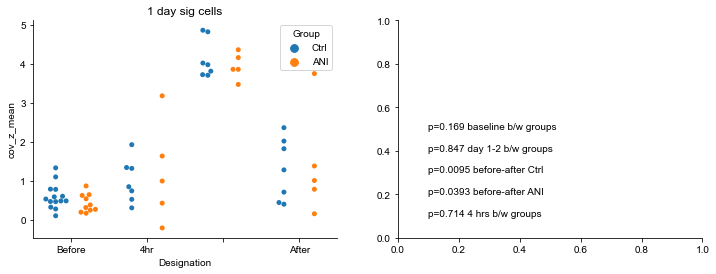

In [194]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))
sns.swarmplot(x="Designation", y="cov_z_mean", hue="Group", data=sig1_dfreg, dodge=True, ax=ax[0])
ax[0].set_title('1 day sig cells')
sns.despine(fig=fig)
stats_before_after(sig1_dfreg, 'cov_z_mean', ax[1])
# fig.savefig(print_dir + "/cov_before_after_sig1_cells_registered_across_days.pdf")

Plot #6: More for ANI turnover plots, but plot turnover from day -2 to day -1 for ANI vs Ctrls and compare to day -1 to day 7 - hypothesis is that ANI induces some sort of change in the cells active during later time points, and day -1 to day 7 is the first point at which we see no suppression of activity by ANI.